In [17]:
import torch
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np

In [83]:
activity_path = "Data/Diffing_Analysis/activity_predictions/"
files = os.listdir(activity_path)

all_data = {} 
for file in files:
    df = pd.read_csv(os.path.join(activity_path, file), header=None, sep="\t|,", engine="python")
    df.columns = ["id", "p1", "p2"]
    all_data[file] = df
all_df = pd.concat(all_data.values())
all_df = all_df[all_df["p1"] < 12]
all_df["iteration"] = all_df["id"].str.split("_").str[-1].str.replace("iteration", "").astype(int)


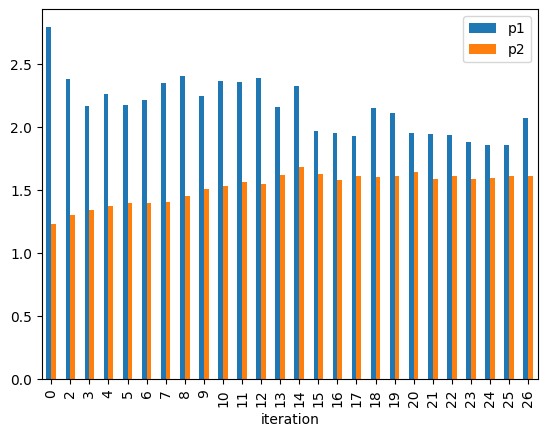

In [91]:
means = pd.DataFrame({
    'p1': all_df.groupby("iteration")["p1"].mean(),
    'p2': all_df.groupby("iteration")["p2"].mean()
})
means.plot(kind="bar")
plt.xlabel("iteration")
plt.show()

# Evolution of the model

/tmp/ipykernel_504291/3066691301.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_cs = torch.load("Data/Diffing_Analysis/all_cs.pt")


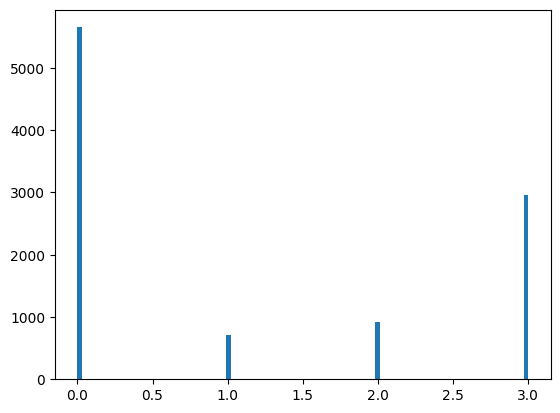

In [123]:
all_cs = torch.load("Data/Diffing_Analysis/all_cs.pt")


name = "M1_D1_vs_M0_D0"
all_mat_sequential = np.zeros((4,10240))
for i in range(1,4):
    name = f"M{i}_D{i}_vs_M{i-1}_D{i-1}"
    cs = all_cs[name]
    changed = np.where(cs < 0.99, 1, 0)
    all_mat_sequential[i] = changed

num_changed = all_mat_sequential.sum(axis=0)
plt.hist(num_changed, bins=100)
plt.show()

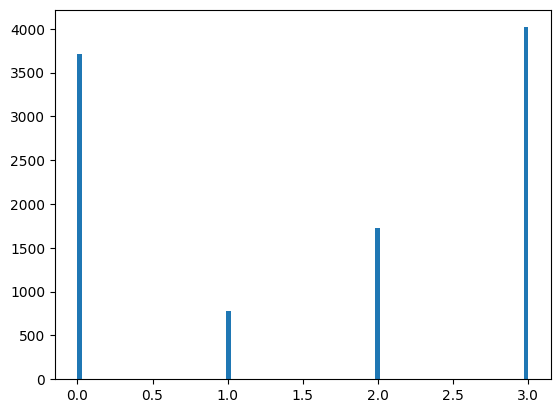

In [126]:

all_mat_against_first = np.zeros((4,10240))
for i in range(1,4):
    name = f"M{i}_D{i}_vs_M{0}_D{0}"
    cs = all_cs[name]
    changed = np.where(cs < 0.99, 1, 0)
    all_mat_against_first[i] = changed

num_changed = all_mat_against_first.sum(axis=0)
plt.hist(num_changed, bins=100)
plt.show()


## Number of features that go:
**change-no change-change**


In [127]:
def analyze_feature_evolution(change_matrix, iterations=None, plot_hist=True):
    """
    Analyze the evolution of features in terms of change/no-change combinations
    across iterations.
    
    Args:
        change_matrix (np.ndarray): A binary matrix of shape (n_iterations, n_features)
            where a value of 1 indicates a change and 0 indicates no change.
        iterations (list, slice, or None): The indices of iterations (rows) to consider.
            If None, then all rows are used.
        plot_hist (bool): Whether to plot a histogram of the evolution patterns frequency.
    
    Returns:
        dict: A dictionary mapping evolution patterns (represented as strings, e.g., "101")
              to a dictionary containing:
                - 'count': Number of features following this pattern.
                - 'indices': List of feature indices that follow this pattern.
    
    Example:
        # Assuming 'all_mat' is the full matrix and you wish to ignore the first row:
        evolution_stats = analyze_feature_evolution(all_mat[1:], plot_hist=True)
        print(evolution_stats)
    """
    if iterations is not None:
        data = change_matrix[iterations, :]
    else:
        data = change_matrix

    n_iter, n_features = data.shape
    evolution = {}

    # Iterate over each feature and build its evolution pattern as a string
    for feature_idx in range(n_features):
        pattern = ''.join(str(int(data[i, feature_idx])) for i in range(n_iter))
        if pattern in evolution:
            evolution[pattern]['count'] += 1
            evolution[pattern]['indices'].append(feature_idx)
        else:
            evolution[pattern] = {'count': 1, 'indices': [feature_idx]}

    # Optionally plot the frequency histogram of the evolution patterns
    if plot_hist:
        import matplotlib.pyplot as plt
        patterns = list(evolution.keys())
        counts = [evolution[pat]['count'] for pat in patterns]
        
        plt.figure(figsize=(8, 5))
        plt.bar(range(len(patterns)), counts, color='skyblue')
        plt.xticks(range(len(patterns)), patterns)
        plt.xlabel("Evolution Pattern (Sequence of 0 = no change, 1 = change)")
        plt.ylabel("Number of Features")
        plt.title("Frequency of Feature Evolution Patterns")
        plt.show()
    
    return evolution



In [130]:

#analyze_feature_evolution(all_mat_against_first, plot_hist=True)
#analyze_feature_evolution(all_mat_sequential, plot_hist=True)


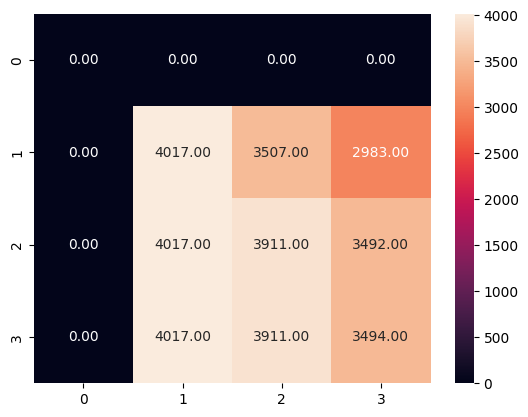

In [135]:
matrix = all_mat_against_first @ all_mat_sequential.T
import seaborn as sns
sns.heatmap(matrix, annot=True, fmt=".2f")
plt.show()


### Avctivit of ablated features